# Diversity Balancing pada Two-Stage Collaborative Filtering

## Import Library

In [1]:
import pandas as pd
import numpy as np
import math 
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Dataset

In [3]:
ratings = pd.read_csv('ratings.csv')
ratings

,userid,itemid,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
...,...,...,...
35492,1508,84,3.5
35493,1508,17,4.0
35494,1508,669,1.0
35495,1508,686,2.5


In [4]:
ratings= ratings.loc[ratings["userid"] <= 60]
ratings

,userid,itemid,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
...,...,...,...
1049,60,13,4.0
1050,60,8,0.5
1051,60,341,4.0
1052,60,318,1.0


In [5]:
trust = pd.read_csv('trust.csv')
trust

,trustor,trustee,value
0,2,966,1
1,2,104,1
2,5,1509,1
3,6,1192,1
4,7,1510,1
...,...,...,...
1848,1507,806,1
1849,1507,361,1
1850,1508,1187,1
1851,1508,509,1


In [6]:
ratings.describe()

,userid,itemid,rating
count,1054.000000,1054.000000,1054.000000
mean,28.236243,146.614801,2.977704
std,17.333612,107.115480,1.079343
min,1.000000,1.000000,0.500000
25%,13.000000,13.000000,2.500000
50%,29.000000,205.000000,3.500000
75%,39.000000,236.000000,4.000000
max,60.000000,341.000000,4.000000


In [7]:
trust.describe()

,trustor,trustee,value
count,1853.000000,1853.000000,1853.0
mean,775.437669,782.192121,1.0
std,447.736536,471.614626,0.0
min,2.000000,2.000000,1.0
25%,410.000000,395.000000,1.0
50%,752.000000,716.000000,1.0
75%,1160.000000,1187.000000,1.0
max,1641.000000,1642.000000,1.0


### Membuat graf untuk 'trust.csv'

In [8]:
G = nx.from_pandas_edgelist(trust, "trustor", "trustee", ["value"], create_using=nx.DiGraph())

## Deklarasi rumus

In [9]:
#helper function 
def itemSetUser(u):
    temp = ratings.loc[ratings['userid'] == u]
    return temp

In [10]:
#helper function (Iuv)
def itemSetBothUser(u,v):
    temp1 = itemSetUser(u)
    temp2 = itemSetUser(v)
    temp3 = temp1.merge(temp2, on=['itemid'])
    return temp3['itemid']

In [11]:
def userRating(u,i):
    rating = 0
    temp = itemSetUser(u)
    row = temp.loc[temp['itemid'] == i]
    if (len(row) != 0):
        rating = row['rating'].values[0]
    else:
        rating = 0
    return rating

In [12]:
#helper function
def avgRatingUser(u):
    temp = itemSetUser(u)
    avg = temp['rating'].mean()
    return avg

In [13]:
def mutualRatingFactor(u,v):
    temp1 = itemSetBothUser(u,v)
    temp2 = itemSetUser(u) 
    x = len(temp1)
    y = len(temp2)
    res = x/y
    return res

In [14]:
def maxPropagation(graph):
    maxLen = 0
    for u in range(1,642):
        if graph.has_node(u):
            length = dict(nx.single_source_shortest_path_length(graph, u))
            for val in length.values():
                if val > maxLen:
                    maxLen = val 
    return maxLen

In [15]:
def userPropagation(graph,u,v):
    val = 0
    if graph.has_node(u) and graph.has_node(v):
        if nx.has_path(graph,u,v):
            val = nx.shortest_path_length(G, source=u, target=v)
        else:
            val = 0
    else:
        val = 0
    return val

In [16]:
#Rumus (3)
def similarity(u,v):
    iuv = itemSetBothUser(u,v)
    if len(iuv) > 0:
        topsum = 0
        botleft = 0
        botright = 0
        for i in range(len(iuv)):
            j = (userRating(u,iuv[i]) - avgRatingUser(u)) * (userRating(v,iuv[i]) - avgRatingUser(v))
            topsum = topsum + j

        for p in range(len(iuv)):
            q = (userRating(u,iuv[p]) - avgRatingUser(u)) * (userRating(u,iuv[p]) - avgRatingUser(u))
            botleft = botleft + q

        for r in range(len(iuv)):
            s = (userRating(v,iuv[r]) - avgRatingUser(v)) * (userRating(v,iuv[r]) - avgRatingUser(v))
            botright = botright + s

        botleft = math.sqrt(abs(botleft))
        botright = math.sqrt(abs(botright))
        if (botleft != 0) and (botright != 0):
            sim = ( topsum / (botleft * botright) ) * mutualRatingFactor(u,v)
        else:
            sim = 0
    else:
        sim = 0
    return sim

In [17]:
#Rumus (2)
def trustRelation(graph,u,v):
    H = maxPropagation(G)
    if (H != 0):
        res = (H - userPropagation(graph,u,v) + 1)/H
    else:
        res = 0
    return res

In [18]:
#Rumus (1)
def trustBasedSimilarity(graph,u,v):
    TS = 0
    sim = similarity(u,v)
    trust = trustRelation(graph,u,v)
    if (sim + trust != 0) and (sim * trust != 0):
        TS = (2 * sim * trust)/(sim + trust)
    elif sim == 0 and trust != 0:
        TS = trust
    elif sim != 0 and trust == 0:
        TS = sim
    return TS

In [19]:
def quanMu(u):
    M = ratings.loc[ratings['userid'] == u]
    return len(M)

def quanMuc(u,c):
    M = clusteredDataRating.loc[(clusteredDataRating['userid'] == u) & (clusteredDataRating['clusters'] == c)]
    return len(M)

def ratingMax(u):
    temp = ratings.loc[ratings['userid'] == u]
    RMax = temp['rating'].max()
    return RMax

def ratingAvgCat(u,c):
    RAvg = 0
    temp = clusteredDataRating.loc[(clusteredDataRating['userid'] == u) & (clusteredDataRating['clusters'] == c)]
    if (len(temp) != 0):
        RAvg = temp['rating'].mean()
        RAvg = round(RAvg,2)
    else:
        RAvg = 0
    return RAvg

In [20]:
def ratingAvgAllCat(u):
    nC = clusteredDataRating['clusters'].nunique()
    RAAvg = 0
    sumsum = 0
    for i in range(nC):
        sumsum = sumsum + averageRatingPref(u,i)
    RAAvg = sumsum / nC
    return RAAvg

In [21]:
#Rumus (4)
def interestDistribution(u,c):
    ID = quanMuc(u,c) / quanMu(u)
    return ID

def averageRatingPref(u,c):
    R = ratingAvgCat(u,c) / ratingMax(u)
    return R

In [22]:
#Rumus (5)
def userPreference(u,c):
    top = 2 * interestDistribution(u,c) * ratingAvgAllCat(u)
    bot = interestDistribution(u,c) * averageRatingPref(u,c)
    if (bot > 0):
        pref = top / bot
    else:
        pref = 0
    return pref

In [23]:
#Rumus (6)
def mutualPreference(u,v):
    nC = clusteredDataRating['clusters'].nunique()
    top = 0
    bot = 0
    tempsum = 0
    for i in range(nC):
        prefU = userPreference(u,i)
        prefV = userPreference(v,i)
        if (prefV >= prefU):
            top = top + prefV
    for i in range(nC):
        temp = userPreference(u,i)
        tempsum = tempsum + temp
    bot = tempsum / nC
    prefUV = top / bot
    return prefUV

In [24]:
#Rumus (7)
def weightAggregation(graph,u,v,theta,gamma):
    W = 0
    TS = trustBasedSimilarity(graph,u,v)
    preUV = mutualPreference(u,v)
    if (TS >= theta):
        W = TS
    elif (TS > 0)  and (TS < theta):
        W = (gamma*TS) + ((1-gamma)*preUV)
    else:
        W = 0
    return W

In [25]:
#Rumus (8)
def ratingPrediction(u,i,graph,theta,gamma,topuser):
    top = 0
    bot = 0
    for j in topuser['userV']:
        temp = 0
        W = weightAggregation(graph,u,j,theta,gamma)
        temp = W * (userRating(j,i) - avgRatingUser(j))
        top = top + temp
        bot = bot + W
    if (bot != 0):
        P = avgRatingUser(u) + (top / bot)
    else:
        P = 0
    return P

In [26]:
#Rumus (9)
def replacementProcedure(candidateList,neglectedList):
    replacementList = pd.DataFrame(columns = ['userid', 'itemid','rating'])
    itemPopularityList = ratings['itemid'].value_counts()
    itemPopularityList = itemPopularityList.to_frame(name='popularity')
    itemPopularityList = itemPopularityList.reset_index()
    itemPopularityList.rename(columns = {'index':'itemid'}, inplace = True)
    
    for p in range(4):
        temp = pd.DataFrame()
        pRow = candidateList.iloc[p:p+1]
        Ri = pRow['rating'].values
        Pi = itemPopularityList['popularity'].values[itemPopularityList['itemid']==pRow['itemid'].values[0]]
        for q in range(len(neglectedList)):
            sim = 1
            qRow = neglectedList.iloc[q:q+1]
            Rj = qRow['rating'].values
            Pj = itemPopularityList['popularity'].values[itemPopularityList['itemid'] == qRow['itemid'].values[0]]
            
            top = Ri - Rj
            bot = Pi[0] - Pj[0]
            if (bot != 0):
                sim = top / bot
            else:
                sim = 0
            row = pd.DataFrame({"itemid":qRow['itemid'].values, "similarity":sim})
            temp = temp.append(row, ignore_index = True)
        temp = temp.sort_values(by=['similarity'], ascending = True)
        for r in range(len(temp)):
            iId = temp['itemid'].iloc[r]
            if iId not in replacementList['itemid'].values:
                tempRow = neglectedList.loc[neglectedList['itemid'] == iId]
                replacementList = replacementList.append(tempRow, ignore_index = True)
                break
    
    return replacementList

## Clustering item ke kategori

In [27]:
data = ratings.drop("userid",axis=1)
data

,itemid,rating
0,1,2.0
1,2,4.0
2,3,3.5
3,4,3.0
4,5,4.0
...,...,...
1049,13,4.0
1050,8,0.5
1051,341,4.0
1052,318,1.0


In [28]:
data.describe()

,itemid,rating
count,1054.000000,1054.000000
mean,146.614801,2.977704
std,107.115480,1.079343
min,1.000000,0.500000
25%,13.000000,2.500000
50%,205.000000,3.500000
75%,236.000000,4.000000
max,341.000000,4.000000


In [29]:
dataUnique = pd.DataFrame(columns = ['itemid', 'avgrating'])

for i in range(1,max(data["itemid"])+1):
    temp = []
    tavgr = 0
    temp = data.loc[data["itemid"] == i]
    tavgr = temp['rating'].sum() / len(temp)
    tavgr = tavgr.round(decimals=2)
    trow = pd.DataFrame({"itemid":[i], "avgrating":[tavgr]})
    dataUnique = dataUnique.append(trow, ignore_index = True)
dataUnique

,itemid,avgrating
0,1,2.92
1,2,3.11
2,3,2.9
3,4,3.16
4,5,3.2
...,...,...
336,337,3.5
337,338,3.0
338,339,2.5
339,340,3.0


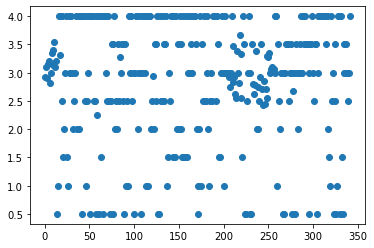

In [30]:
plt.scatter(dataUnique['itemid'],dataUnique['avgrating'],cmap='rainbow')

In [31]:
scaler = StandardScaler()
scaledFeatures = scaler.fit_transform(dataUnique)
scaledFeatures

array([[-1.72697891,  0.07081902],
       [-1.71682021,  0.24770277],
       [-1.70666151,  0.05219968],
       [-1.69650281,  0.29425112],
       [-1.68634411,  0.33148981],
       [-1.67618541, -0.03158736],
       [-1.66602671,  0.14529639],
       [-1.65586801,  0.47113487],
       [-1.64570931,  0.52699289],
       [-1.63555061,  0.26632211],
       [-1.62539191,  0.64801862],
       [-1.61523321,  0.2383931 ],
       [-1.60507451,  0.34079948],
       [-1.59491581, -2.18212133],
       [-1.58475711, -1.71663779],
       [-1.57459841,  1.07626348],
       [-1.56443971,  0.44320586],
       [-1.55428102,  1.07626348],
       [-1.54412232,  1.07626348],
       [-1.53396362, -0.32018716],
       [-1.52380492, -1.25115424],
       [-1.51364622, -0.7856707 ],
       [-1.50348752,  0.14529639],
       [-1.49332882,  1.07626348],
       [-1.48317012, -1.25115424],
       [-1.47301142, -1.71663779],
       [-1.46285272,  1.07626348],
       [-1.45269402,  0.14529639],
       [-1.44253532,

In [32]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaledFeatures)
    sse.append(kmeans.inertia_)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


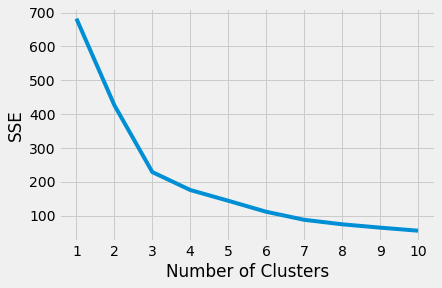

In [33]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [34]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [35]:
kmeans = KMeans(3)
kmeans.fit(scaledFeatures)
identifiedClusters = kmeans.fit_predict(scaledFeatures)

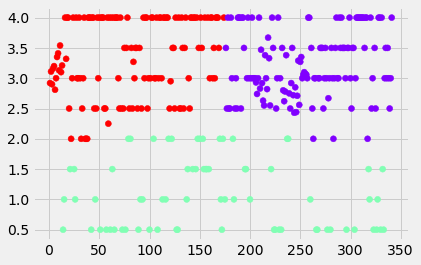

In [36]:
dataWithClusters = dataUnique.copy()
dataWithClusters['clusters'] = identifiedClusters 
plt.scatter(dataWithClusters['itemid'],dataWithClusters['avgrating'],c=dataWithClusters['clusters'],cmap='rainbow')

In [37]:
dataWithClusters = dataWithClusters.drop('avgrating', axis=1)
dataWithClusters

,itemid,clusters
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2
...,...,...
336,337,0
337,338,0
338,339,0
339,340,0


In [38]:
clusteredDataRating = pd.merge(left=ratings, right=dataWithClusters, how='left', left_on='itemid', right_on='itemid')
clusteredDataRating

,userid,itemid,rating,clusters
0,1,1,2.0,2
1,1,2,4.0,2
2,1,3,3.5,2
3,1,4,3.0,2
4,1,5,4.0,2
...,...,...,...,...
1049,60,13,4.0,2
1050,60,8,0.5,2
1051,60,341,4.0,0
1052,60,318,1.0,1


## Algoritma Diversity Balancing for Two-Stage collaborative ﬁltering (DBTS)

In [39]:
def DBTS(ratings, trust, u, theta = 0.4, gamma = 0.4):
    #start = datetime.now()
    recList = pd.DataFrame()
    
    # Stage 1: pembentukan daftar kandidat
    userList = pd.DataFrame(columns = ['userV', 'TSvalue', 'similarity','weight'])
    for v in range(1,max(ratings['userid'])):
        TS = trustBasedSimilarity(G,u,v)
        if (TS >= theta):
            userList = userList.append({"userV":v,'TSvalue':TS,"similarity":1,"weight":0}, ignore_index = True)
        elif (TS < theta):
            userList = userList.append({"userV":v,'TSvalue':TS,"similarity":0,"weight":0}, ignore_index = True)

    for w in range(len(userList)):
        sim = -1
        sim = userList['similarity'].loc[userList.index[w]]
        if (sim == 1):
            userList['weight'].loc[userList.index[w]] = userList['TSvalue'].loc[userList.index[w]]
        elif (sim == 0):
            TS = 0
            TS = userList['TSvalue'].loc[userList.index[w]]
            userV = userList['userV'].loc[userList.index[w]]
            preUV = mutualPreference(u,userV)
            userList['weight'].loc[userList.index[w]] = (gamma*TS) + ((1-gamma)*preUV)
        else:
            userList['weight'].loc[userList.index[w]] = 0
            
    # Prediksi rating dan peringkat
    sortedUserList = userList.sort_values(by=['weight'], ascending = False)
    topUser = sortedUserList.head(n=3)
    itemRatingList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    ratedItemList = itemSetUser(u)
    for x in range(1,max(ratings['itemid'])+1):
        ratingItem = 0
        if (x in set(ratedItemList['itemid'])):
            ratingItem = ratedItemList['rating'].values[ratedItemList['itemid'] == x]
            itemRatingList = itemRatingList.append({'userid':u,'itemid':x,'rating':ratingItem[0]}, ignore_index = True)
        else:
            ratingItem = ratingPrediction(u,x,G,theta,gamma,topUser)
            ratingItem = round(ratingItem,2)
            itemRatingList = itemRatingList.append({'userid':u,'itemid':x,'rating':ratingItem}, ignore_index = True)
            
    sortedItemRatingList = itemRatingList.sort_values(by=['rating'], ascending = False)
    candidateList = sortedItemRatingList.head(n=10)
    candidateList = candidateList.reset_index(drop=True)
    neglectedList = sortedItemRatingList.iloc[10:40,:]
    neglectedList = neglectedList.reset_index(drop=True)
    
    # Stage 2: penggantian item dan pembentukan daftar rekomendasi
    replacementItems = replacementProcedure(candidateList,neglectedList)
    candidateList = candidateList.drop([0,1,2,3],axis=0)
    replacementItems = replacementItems.append(candidateList)
    replacementItems = replacementItems.astype({"userid":'int64', "itemid":'int64'})
    
    #end = datetime.now()
    #print("time elapsed: ",end-start)
   
    
    return replacementItems

## Evaluasi Sistem Rekomendasi

In [40]:
allUserRecList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
start = datetime.now()
for u in ratings['userid'].unique():
    recList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    recList = DBTS(ratings, trust, u)
    allUserRecList = allUserRecList.append(recList)
end = datetime.now()
time = end-start
print("time elapsed: ",time)   
allUserRecList

time elapsed:  4:01:28.833604


,userid,itemid,rating
0,1,257,0.8
1,1,247,0.8
2,1,248,0.8
3,1,249,0.8
4,1,232,4.3
...,...,...,...
5,60,211,1.39
6,60,239,1.39
7,60,213,1.14
8,60,241,1.14


In [41]:
def precisionRecallAtK(recList, ratings, k=10, threshold = 3.0):
    precList = pd.DataFrame(columns=['precision', 'recall'])
    
    for uid in recList['userid'].unique():
        userRating = recList.loc[recList['userid'] == uid]
        trueRating = ratings.loc[ratings['userid'] == uid]
        userRatingSorted = userRating.sort_values(by=['rating'], ascending = False)
        trueRatingSorted = trueRating.sort_values(by=['rating'], ascending = False)
        
        relevantItem = sum((rating >= threshold) for (rating) in trueRatingSorted['rating'][:k])
        recommendedItem = sum((rating >= threshold) for (rating) in userRatingSorted['rating'][:k])
        
        rel = userRatingSorted.loc[userRatingSorted['rating'] >= threshold]
        rec = trueRatingSorted.loc[trueRatingSorted['rating'] >= threshold]
        recRel = pd.merge(rel, rec, on=['userid','itemid'], how='left', indicator='Exist')
        recRel['exist'] = np.where(recRel.Exist == 'both', True, False)
        relAndRecItem = sum(recRel['exist'] == True)
        
        precision = relAndRecItem / recommendedItem if recommendedItem != 0 else 1
        recall = relAndRecItem / relevantItem if relevantItem != 0 else 1
        trow = pd.DataFrame({"precision":[precision], "recall":[recall]})
        precList = precList.append(trow)
        
    return precList

In [42]:
from itertools import combinations

def personalDiversity(recList):
    index = list(range(1, max(ratings['itemid']+1)))
    itemSimilar = pd.DataFrame(cosine_similarity(matrix.T.fillna(0)), index=index, columns=index)
    PD = 0
    sumIter = 0
    U = len(allUserRecList['userid'].unique())
    for uid in recList['userid'].unique():
        userList = recList.loc[recList['userid'] == uid]
        Lu = len(userList)
        top = 0
        bot = 0
        res = 0
        for combo in combinations(userList['itemid'], 2):
            top = top + (1 - itemSimilar.iloc[combo[0]-1,combo[1]-1])
        bot = 0.5 * Lu * (Lu-1)
        res = 1 - (top/bot) if bot != 0 else 1
        sumIter = sumIter + res
    PD = 1/U * sumIter if U != 0 else -1
        
    return PD

In [43]:
def aggregateDiversity(recList):
    AD = 0
    Lu = len(recList['itemid'].unique())
    I = max(recList['itemid'])
    AD = Lu/I
    return AD

In [44]:
matrix = ratings.pivot_table(index='userid', columns='itemid', values='rating')
matrixNorm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrixNorm.head()

itemid,1,2,3,4,5,6,7,8,9,10,...,332,333,334,335,336,337,338,339,340,341
userid,,,,,,,,,,,,,,,,,,,,,
1,-1.416667,0.583333,0.083333,-0.416667,0.583333,0.083333,0.083333,-0.416667,-0.916667,0.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,-2.329016,NaN,NaN,NaN,0.670984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.666667,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
results=[]
for i in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 1.5)

    # Precision and recall can then be averaged over all users
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    
PD = personalDiversity(allUserRecList)
results.append({'Personal Diversity': PD})
AD = aggregateDiversity(allUserRecList)
results.append({'Aggregate Diversity': AD})
results

[{'K': 6, 'Precision': 0.6527777777777776, 'Recall': 0.5680555555555556},
 {'K': 7, 'Precision': 0.5789682539682538, 'Recall': 0.49583333333333324},
 {'K': 8, 'Precision': 0.5301587301587302, 'Recall': 0.44374999999999987},
 {'K': 9, 'Precision': 0.49798280423280417, 'Recall': 0.40324074074074073},
 {'K': 10, 'Precision': 0.475760582010582, 'Recall': 0.37324074074074065},
 {'Personal Diversity': 0.5301269157223669},
 {'Aggregate Diversity': 0.37091988130563797}]

In [46]:
results=[]
for i in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 2.0)

    # Precision and recall can then be averaged over all users
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    
PD = personalDiversity(allUserRecList)
results.append({'Personal Diversity': PD})
AD = aggregateDiversity(allUserRecList)
results.append({'Aggregate Diversity': AD})
results

[{'K': 6, 'Precision': 0.7277777777777775, 'Recall': 0.571388888888889},
 {'K': 7, 'Precision': 0.6575396825396823, 'Recall': 0.5007539682539681},
 {'K': 8, 'Precision': 0.6117063492063491, 'Recall': 0.44956349206349194},
 {'K': 9, 'Precision': 0.5862433862433861, 'Recall': 0.4116005291005291},
 {'K': 10, 'Precision': 0.5682804232804233, 'Recall': 0.38289682539682535},
 {'Personal Diversity': 0.5301269157223669},
 {'Aggregate Diversity': 0.37091988130563797}]

In [47]:
results=[]
for i in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 2.5)

    # Precision and recall can then be averaged over all users
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    
PD = personalDiversity(allUserRecList)
results.append({'Personal Diversity': PD})
AD = aggregateDiversity(allUserRecList)
results.append({'Aggregate Diversity': AD})
results

[{'K': 6, 'Precision': 0.7833333333333332, 'Recall': 0.5630555555555556},
 {'K': 7, 'Precision': 0.7246031746031746, 'Recall': 0.49757936507936507},
 {'K': 8, 'Precision': 0.689484126984127, 'Recall': 0.44936507936507936},
 {'K': 9, 'Precision': 0.665873015873016, 'Recall': 0.41464285714285715},
 {'K': 10, 'Precision': 0.651058201058201, 'Recall': 0.3874206349206349},
 {'Personal Diversity': 0.5301269157223669},
 {'Aggregate Diversity': 0.37091988130563797}]

In [48]:
results=[]
for i in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 3.0)

    # Precision and recall can then be averaged over all users
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    
PD = personalDiversity(allUserRecList)
results.append({'Personal Diversity': PD})
AD = aggregateDiversity(allUserRecList)
results.append({'Aggregate Diversity': AD})
results

[{'K': 6, 'Precision': 0.8, 'Recall': 0.5366666666666667},
 {'K': 7, 'Precision': 0.753174603174603, 'Recall': 0.4803174603174602},
 {'K': 8, 'Precision': 0.7266865079365079, 'Recall': 0.4398412698412698},
 {'K': 9, 'Precision': 0.713723544973545, 'Recall': 0.4102116402116403},
 {'K': 10, 'Precision': 0.7046494708994708, 'Recall': 0.38743386243386246},
 {'Personal Diversity': 0.5301269157223669},
 {'Aggregate Diversity': 0.37091988130563797}]

In [49]:
results=[]
for i in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 3.5)

    # Precision and recall can then be averaged over all users
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    
PD = personalDiversity(allUserRecList)
results.append({'Personal Diversity': PD})
AD = aggregateDiversity(allUserRecList)
results.append({'Aggregate Diversity': AD})
results

[{'K': 6, 'Precision': 0.8405555555555557, 'Recall': 0.5188888888888888},
 {'K': 7, 'Precision': 0.8107936507936508, 'Recall': 0.47563492063492063},
 {'K': 8, 'Precision': 0.7971031746031747, 'Recall': 0.4449801587301587},
 {'K': 9, 'Precision': 0.7864550264550265, 'Recall': 0.4232208994708995},
 {'K': 10, 'Precision': 0.7792328042328044, 'Recall': 0.40655423280423275},
 {'Personal Diversity': 0.5301269157223669},
 {'Aggregate Diversity': 0.37091988130563797}]

In [50]:
results=[]
for i in range(4, 11):
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=i)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    results.append({'item': i, 'PD': PD, 'AD': AD})

precRec = precisionRecallAtK(allUserRecList, ratings, k=8, threshold = 3.5)
prec = precRec['precision'].mean()
rec =  precRec['recall'].mean()
results.append({'K': 8, 'Precision': prec, 'Recall': rec})
    

results

[{'item': 4, 'PD': 0.5006994866866553, 'AD': 0.2789317507418398},
 {'item': 5, 'PD': 0.5009720293609612, 'AD': 0.29376854599406527},
 {'item': 6, 'PD': 0.508530035762119, 'AD': 0.314540059347181},
 {'item': 7, 'PD': 0.5249402839738967, 'AD': 0.3264094955489614},
 {'item': 8, 'PD': 0.5270144492031487, 'AD': 0.33827893175074186},
 {'item': 9, 'PD': 0.5245904138673053, 'AD': 0.3560830860534125},
 {'item': 10, 'PD': 0.5301269157223669, 'AD': 0.37091988130563797},
 {'K': 8, 'Precision': 0.7971031746031747, 'Recall': 0.4449801587301587}]

In [51]:
listVal = pd.DataFrame(columns = ['threshold', 'i', 'precision', 'recall'])
th = [1.5, 2.0, 2.5, 3.0, 3.5]
for t in th:
    for i in range(6, 11):
        precRec = precisionRecallAtK(allUserRecList, ratings, k=i, threshold = 3.5)

        # Precision and recall can then be averaged over all users
        prec = precRec['precision'].mean()
        rec =  precRec['recall'].mean()
        listVal = listVal.append({'threshold':t, 'i':i, 'precision':prec, 'recall':rec}, ignore_index=True)
listVal

,threshold,i,precision,recall
0,1.5,6.0,0.840556,0.518889
1,1.5,7.0,0.810794,0.475635
2,1.5,8.0,0.797103,0.44498
3,1.5,9.0,0.786455,0.423221
4,1.5,10.0,0.779233,0.406554
5,2.0,6.0,0.840556,0.518889
6,2.0,7.0,0.810794,0.475635
7,2.0,8.0,0.797103,0.44498
8,2.0,9.0,0.786455,0.423221
9,2.0,10.0,0.779233,0.406554


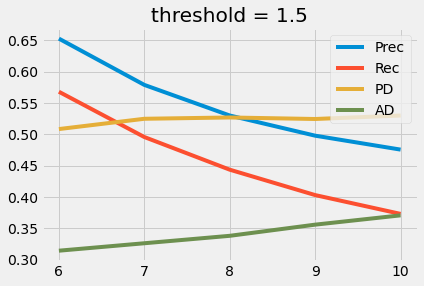

In [61]:
listVal = pd.DataFrame(columns = ['i', 'precision', 'recall', 'PD', 'AD'])
for x in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=x, threshold = 1.5)
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=x)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    listVal = listVal.append({'i':x, 'precision': prec, 'recall': rec, 'PD': PD, 'AD': AD}, ignore_index=True)


plt.plot(listVal['i'], listVal['precision'], label = "Prec")
plt.plot(listVal['i'], listVal['recall'], label = "Rec")
plt.plot(listVal['i'], listVal['PD'], label = "PD")
plt.plot(listVal['i'], listVal['AD'], label = "AD")
plt.title('threshold = 1.5')
plt.legend()
plt.show()


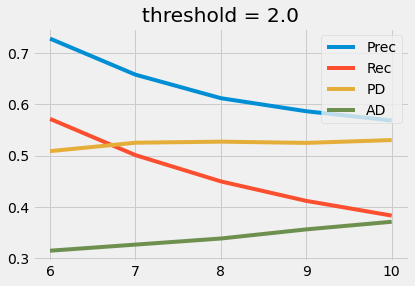

In [62]:
listVal = pd.DataFrame(columns = ['i', 'precision', 'recall', 'PD', 'AD'])
for x in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=x, threshold = 2.0)
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=x)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    listVal = listVal.append({'i':x, 'precision': prec, 'recall': rec, 'PD': PD, 'AD': AD}, ignore_index=True)
    
plt.plot(listVal['i'], listVal['precision'], label = "Prec")
plt.plot(listVal['i'], listVal['recall'], label = "Rec")
plt.plot(listVal['i'], listVal['PD'], label = "PD")
plt.plot(listVal['i'], listVal['AD'], label = "AD")
plt.title('threshold = 2.0')
plt.legend()
plt.show()

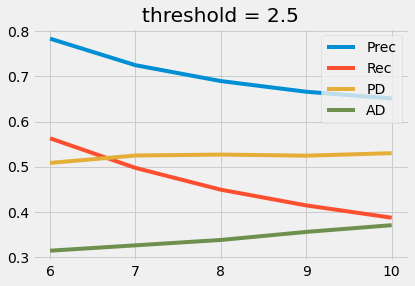

In [63]:
listVal = pd.DataFrame(columns = ['i', 'precision', 'recall', 'PD', 'AD'])
for x in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=x, threshold = 2.5)
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=x)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    listVal = listVal.append({'i':x, 'precision': prec, 'recall': rec, 'PD': PD, 'AD': AD}, ignore_index=True)
    
plt.plot(listVal['i'], listVal['precision'], label = "Prec")
plt.plot(listVal['i'], listVal['recall'], label = "Rec")
plt.plot(listVal['i'], listVal['PD'], label = "PD")
plt.plot(listVal['i'], listVal['AD'], label = "AD")
plt.title('threshold = 2.5')
plt.legend()
plt.show()

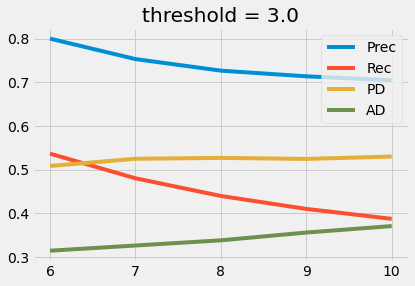

In [64]:
listVal = pd.DataFrame(columns = ['i', 'precision', 'recall', 'PD', 'AD'])
for x in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=x, threshold = 3.0)
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=x)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    listVal = listVal.append({'i':x, 'precision': prec, 'recall': rec, 'PD': PD, 'AD': AD}, ignore_index=True)
    
plt.plot(listVal['i'], listVal['precision'], label = "Prec")
plt.plot(listVal['i'], listVal['recall'], label = "Rec")
plt.plot(listVal['i'], listVal['PD'], label = "PD")
plt.plot(listVal['i'], listVal['AD'], label = "AD")
plt.title('threshold = 3.0')
plt.legend()
plt.show()

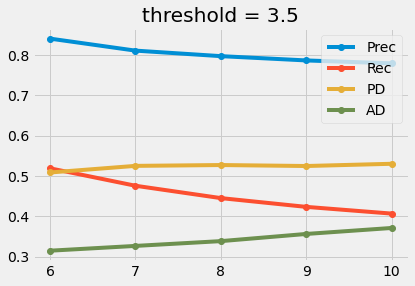

In [65]:
listVal = pd.DataFrame(columns = ['i', 'precision', 'recall', 'PD', 'AD'])
i = [6,7,8,9,10]
for x in range(6, 11):
    precRec = precisionRecallAtK(allUserRecList, ratings, k=x, threshold = 3.5)
    prec = precRec['precision'].mean()
    rec =  precRec['recall'].mean()
    droppedList = pd.DataFrame(columns = ['userid', 'itemid', 'rating'])
    for u in allUserRecList['userid'].unique():
        taken = allUserRecList.loc[allUserRecList['userid'] == u].head(n=x)
        droppedList = droppedList.append(taken)
    PD = personalDiversity(droppedList)
    AD = aggregateDiversity(droppedList)
    listVal = listVal.append({'i':x, 'precision': prec, 'recall': rec, 'PD': PD, 'AD': AD}, ignore_index=True)
    
plt.plot(listVal['i'], listVal['precision'], label = "Prec", marker='o')
plt.plot(listVal['i'], listVal['recall'], label = "Rec", marker='o')
plt.plot(listVal['i'], listVal['PD'], label = "PD", marker='o')
plt.plot(listVal['i'], listVal['AD'], label = "AD", marker='o')
plt.title('threshold = 3.5')
plt.legend()
plt.show()